In [1]:
%autosave 0

Autosave disabled


In [2]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape

In [3]:
stack_idx = '16'
models = '1-27'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True
add_intercept = True

### Read CV predictions and test

In [4]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [5]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [6]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [7]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [8]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [9]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [10]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
27
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.000

In [11]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [12]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.368623,12.139520,6.452832e+05,13.377446,12.148343,6.477905e+05,13.381324,12.152221,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.964998,13.568430,3.164660e+06,14.967557,13.570989,3.127411e+06,14.955716,13.559149,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.099372,14.379417,9.832843e+06,16.101239,14.381284,9.745913e+06,16.092359,14.372404,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.360680,13.753334,1.274179e+07,16.360398,13.753051,1.259548e+07,16.348848,13.741502,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.950262,12.405236,1.114412e+06,13.923838,12.378812,1.131428e+06,13.938992,12.393966,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_24,pred_25,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.189986,1.456214e+07,16.493936,15.264829,1.358120e+07,16.424197,15.195091,1.405424e+07,16.458435,15.229328
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.140432,3.903389e+06,15.177356,13.132737,3.915563e+06,15.180470,13.135851,3.932854e+06,15.184876,13.140257
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.643765,1.064055e+07,16.180183,13.681162,1.076414e+07,16.191730,13.692710,1.040041e+07,16.157355,13.658335
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.778239,6.006309e+06,15.608321,14.796389,6.034948e+06,15.613078,14.801146,5.905111e+06,15.591329,14.779397
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.188114,1.091787e+06,13.903327,12.143065,1.096191e+06,13.907353,12.147091,1.048505e+06,13.862877,12.102615


### Check models scores

In [13]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-24 5866.873835
24 model-25 5908.874238
25 model-26 5918.873998
26 model-27 5892.873194


In [14]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [15]:
def objective(x, metric):
    cv_pred_final = cv.loc[:,cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    global best_score
    global best_coeffs
    global best_hit
    hit = cal_score(cv['total_price'], cv_pred_final)
    score = cal_mape(cv['total_price'], cv_pred_final)
#    if score > best_score[metric]:
    if score < best_score[metric]:
        best_score[metric] = score
        best_hit[metric] = hit
        best_coeffs[metric] = x.copy()
#        print('find better score:')
#        print('score: ', score)
#        print('coeffs: ', x)
#        print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Optimize

In [16]:
best_score = {}
best_coeffs = {}
best_hit = {}

len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [ [1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)] ]

#for metric in ['mape']:
for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 1
    best_hit[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        try:
            display(minimize(objective, x0, args=(metric), tol=1e-4))
        except:
            pass

Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]



      fun: 0.12291635410214327
 hess_inv: array([[ 4.53897230e+01, -4.05335959e+00, -7.97153971e+00,
         7.98970503e+00,  1.46117474e+01, -4.20143145e+01,
         1.19321845e+00,  7.85294845e+00,  2.54872342e+01,
         5.14898170e+00, -4.33088277e+00, -5.62313884e+00,
         7.78285909e+00,  1.39819101e+02, -2.17451248e+01,
        -6.40875862e+01, -8.24909706e+00, -8.37424269e+01,
         3.65168915e+01, -1.40278663e+02, -4.07950243e+01,
         2.98024227e+01,  9.43842810e+00,  1.26925849e+01,
         5.08684810e+01,  4.15829011e+01, -1.34020436e+01,
         1.93392279e+00],
       [-4.05335970e+00,  9.63168230e+00, -4.92161794e+00,
        -1.25784378e-01, -4.92378840e+00,  6.50876577e+00,
         1.07899752e+00, -9.16758961e+00,  2.78620608e+00,
        -3.58628376e+00,  1.45965241e+00,  3.29716615e+00,
        -6.12786521e+00, -1.46039339e+01, -1.25542791e+00,
         7.80355448e+00,  3.63323113e+00,  1.38199890e+01,
         1.40099597e+00,  1.32502562e+01,  2.33

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



      fun: 1.0
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]



      fun: 1.000002081631378
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]



      fun: 0.9096742379855587
 hess_inv: array([[ 2.86211877e+03, -1.41675880e+03,  2.59026631e+03,
         3.40490358e+02,  9.86241693e+02, -1.34584949e+03,
         6.48057923e+02, -1.05793496e+02,  5.34017430e+02,
        -5.42474113e+02,  2.20690991e+02, -4.93788301e+02,
         7.59754658e+02,  3.67068777e+02, -7.99692652e+02,
        -1.83753839e+03, -3.39383628e+03, -2.69622966e+03,
        -1.86318779e+02,  3.03382185e+03, -1.66183929e+03,
         8.26109103e+02, -8.43624563e+02,  9.78540955e+02,
         5.57802482e+03, -4.79218301e+03,  4.66115639e+02,
        -9.71993935e+02],
       [-1.41675880e+03,  1.06937356e+03, -1.75310846e+03,
        -1.32761812e+02, -1.13195384e+03,  5.26269572e+02,
        -4.67944021e+02,  8.95956920e+01, -1.79278753e+02,
         6.20638168e+02, -1.58950951e+02,  2.72821716e+02,
        -5.97171310e+02, -4.19073207e+02,  2.79247067e+02,
         1.19619650e+03,  2.27397467e+03,  1.46448607e+03,
        -5.92364908e+01, -1.46686915e+03,  2.111

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


      fun: 1.0150351053760821e+51
 hess_inv: array([[ 0.96303265, -0.03714647, -0.03693918, -0.03682514, -0.03710795,
        -0.03692601, -0.03727779, -0.03764798, -0.03693897, -0.0369447 ,
        -0.03615516, -0.03699239, -0.03759499, -0.03694422, -0.03694659,
        -0.0369506 , -0.03694501, -0.03694253, -0.03692909, -0.03694994,
        -0.03714178, -0.03712384, -0.03693977, -0.03695025, -0.0369292 ,
        -0.03692686, -0.0368913 , -0.00211266],
       [-0.03714647,  0.96267355, -0.03711817, -0.03700356, -0.03728775,
        -0.03710493, -0.03745842, -0.0378304 , -0.03711795, -0.03712371,
        -0.03633034, -0.03717163, -0.03777715, -0.03712323, -0.0371256 ,
        -0.03712964, -0.03712402, -0.03712152, -0.03710803, -0.03712897,
        -0.03732174, -0.03730371, -0.03711875, -0.03712928, -0.03710813,
        -0.03710578, -0.03707005, -0.0021229 ],
       [-0.03693918, -0.03711817,  0.96308896, -0.03679708, -0.03707968,
        -0.03689788, -0.03724939, -0.0376193 , -0.036910

Optimizing with init x0: [0.1638873597001715, 1.6627977326010113, 1.1583258258006952, 1.33065474386598, -0.8143802819722342, 0.08004716740387807, 0.3769016110497362, 0.8661132638121549, -0.11570070055800045, 0.497327708157725, 0.8246800223101958, 0.46931574298790957, -0.5154294514953071, 0.3236789258963454, -0.04986048561275454, 0.1279624225118241, 0.060923748829192284, 0.45704546767667753, -0.1913596011331818, -0.23010273826314864, -1.5412739888089468, 0.2362252531037939, -0.11387162233469524, 1.4128694923060179, -0.08848917990439463, 1.5734888860051357, 0.8195864459829476, -0.8102091487503139]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


      fun: 8616181788132051.0
 hess_inv: array([[ 0.96327188, -0.0385581 , -0.03687573, -0.03619112, -0.0355411 ,
        -0.03689994, -0.03698855, -0.03862773, -0.03695374, -0.03691665,
        -0.03630153, -0.03738085, -0.03719409, -0.03692648, -0.03692231,
        -0.03684061, -0.03691979, -0.03687538, -0.03691944, -0.03698955,
        -0.0358371 , -0.03575507, -0.03687649, -0.03683206, -0.03695177,
        -0.03691507, -0.03688806, -0.00213708],
       [-0.0385581 ,  0.95952074, -0.03871307, -0.03799435, -0.03731194,
        -0.03873848, -0.03883151, -0.04055236, -0.03879497, -0.03875603,
        -0.03811026, -0.03924336, -0.03904729, -0.03876635, -0.03876197,
        -0.0386762 , -0.03875932, -0.0387127 , -0.03875896, -0.03883256,
        -0.03762269, -0.03753657, -0.03871386, -0.03866722, -0.0387929 ,
        -0.03875437, -0.03872601, -0.00224356],
       [-0.03687573, -0.03871307,  0.96297606, -0.03633658, -0.03568394,
        -0.03704824, -0.03713721, -0.03878298, -0.03710226, 

Optimizing with init x0: [-0.45270118632061823, -0.9190427296492489, -1.6527207368882515, 0.07448144476133939, 1.7153759762575023, 0.3200668868537763, 0.8351911069431762, 0.9852509102891724, 0.46150357789572166, 1.0414724356604057, -0.7594835024556132, 0.014764961697727941, -0.3773854851392548, -1.489241491397139, -0.5687164237185491, 0.1984143747808949, -0.6213219189621197, -1.3084726043040042, -0.17320514842585244, 0.4953700910215406, -0.8092972245429683, -0.9618668504699571, -0.2715725969955254, -0.28597938818132485, 0.806901569845114, 0.9547695518290725, 1.8679532031455368, -1.0532976284760973]



      fun: 1.0000020816196258
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Optimizing with init x0: [-0.2447103206091833, -1.0215700344901417, -0.18490199139042474, -0.17637758921109714, -1.534334376751676, -0.3834213908463088, -1.9160477974024028, 0.6061415256927639, 1.5737185174366624, 0.396392679836083, -0.012514507810505518, 1.716160213925986, 1.707051505427852, 1.8162028798149126, 1.393703192605895, 0.3649919202062421, 0.2860168072993833, 1.1660530152838495, 0.9322253151929961, 0.9853954788343905, 0.26009092834251274, 1.15965840851404, 1.6597238605510225, 0.25314670325127847, 1.7980854921039018, -0.5695216000748724, -0.5566007834856066, -0.7098213568997659]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


      fun: 1.8885679120779765e+35
 hess_inv: array([[ 0.96302003, -0.03720276, -0.03696891, -0.03682553, -0.03703552,
        -0.03695899, -0.03719487, -0.03757683, -0.03697296, -0.03697734,
        -0.03618301, -0.03701013, -0.037498  , -0.03697583, -0.03697817,
        -0.03697973, -0.03697746, -0.03697289, -0.03696448, -0.03698181,
        -0.03708179, -0.03706515, -0.03696172, -0.03696792, -0.03696753,
        -0.03696243, -0.03692824, -0.0021174 ],
       [-0.03720276,  0.9625731 , -0.03719164, -0.03704739, -0.03725865,
        -0.03718165, -0.03741896, -0.03780321, -0.03719571, -0.03720012,
        -0.036401  , -0.0372331 , -0.03772391, -0.0371986 , -0.03720095,
        -0.03720252, -0.03720023, -0.03719564, -0.03718718, -0.03720461,
        -0.0373052 , -0.03728846, -0.0371844 , -0.03719064, -0.03719025,
        -0.03718512, -0.03715072, -0.00213015],
       [-0.03696891, -0.03719164,  0.96304215, -0.03681452, -0.03702444,
        -0.03694793, -0.03718375, -0.03756559, -0.036961

Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]



      fun: 1642417.2064573355
 hess_inv: array([[ 1.98426893e-05, -1.26377741e-06, -1.48848204e-05,
         6.87240223e-07,  1.08637303e-05,  8.62355066e-06,
        -1.55542467e-06,  1.86239203e-06, -2.06338956e-05,
         5.95081596e-05, -3.01574741e-06, -5.54354524e-06,
         5.77208682e-06,  5.22588178e-05, -3.52431505e-05,
        -7.13821734e-05, -3.96956931e-05,  2.06320719e-05,
         6.74199783e-05,  2.02276104e-05,  1.63222321e-05,
        -2.73223446e-05,  9.73511727e-07, -1.15693009e-06,
        -4.17977237e-05, -2.53584971e-05,  3.86424940e-06,
        -3.06428159e-08],
       [-1.26455022e-06,  3.28277012e-07, -8.33251902e-08,
         2.10860111e-08, -4.83363404e-07,  5.82888439e-07,
         8.09439905e-08, -2.42092398e-07,  5.62481884e-07,
        -2.85067359e-06,  1.47879735e-08,  1.01896225e-07,
        -1.20975279e-07, -4.28996730e-06,  2.36427307e-06,
         4.90555667e-06,  2.68763689e-06, -1.39979922e-06,
        -6.01290146e-06, -1.29342526e-06, -8.629

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



      fun: 12937270.809873717
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]



      fun: 12937280.994235411
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]



      fun: 12937183.38494895
 hess_inv: array([[ 0.96307844, -0.03741592, -0.03693202, -0.03670032, -0.0368063 ,
        -0.03693869, -0.03716642, -0.03775945, -0.03696286, -0.03694898,
        -0.03622743, -0.03702112, -0.03747214, -0.03695241, -0.03695239,
        -0.03694574, -0.03695324, -0.03694248, -0.03694767, -0.03696778,
        -0.03690148, -0.03687577, -0.0369235 , -0.03692014, -0.03695387,
        -0.03694589, -0.03689898, -0.00212347],
       [-0.03741592,  0.96208309, -0.03742652, -0.03719173, -0.03729912,
        -0.03743329, -0.03766406, -0.03826504, -0.03745778, -0.03744371,
        -0.0367125 , -0.03751682, -0.03797388, -0.03744719, -0.03744717,
        -0.03744043, -0.03744803, -0.03743712, -0.03744239, -0.03746277,
        -0.03739557, -0.03736953, -0.03741789, -0.03741449, -0.03744867,
        -0.03744059, -0.03739304, -0.0021519 ],
       [-0.03693202, -0.03742652,  0.96305752, -0.03671072, -0.03681673,
        -0.03694916, -0.03717695, -0.03777015, -0.03697333, -

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.1638873597001715, 1.6627977326010113, 1.1583258258006952, 1.33065474386598, -0.8143802819722342, 0.08004716740387807, 0.3769016110497362, 0.8661132638121549, -0.11570070055800045, 0.497327708157725, 0.8246800223101958, 0.46931574298790957, -0.5154294514953071, 0.3236789258963454, -0.04986048561275454, 0.1279624225118241, 0.060923748829192284, 0.45704546767667753, -0.1913596011331818, -0.23010273826314864, -1.5412739888089468, 0.2362252531037939, -0.11387162233469524, 1.4128694923060179, -0.08848917990439463, 1.5734888860051357, 0.8195864459829476, -0.8102091487503139]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [-0.45270118632061823, -0.9190427296492489, -1.6527207368882515, 0.07448144476133939, 1.7153759762575023, 0.3200668868537763, 0.8351911069431762, 0.9852509102891724, 0.46150357789572166, 1.0414724356604057, -0.7594835024556132, 0.014764961697727941, -0.3773854851392548, -1.489241491397139, -0.5687164237185491, 0.1984143747808949, -0.6213219189621197, -1.3084726043040042, -0.17320514842585244, 0.4953700910215406, -0.8092972245429683, -0.9618668504699571, -0.2715725969955254, -0.28597938818132485, 0.806901569845114, 0.9547695518290725, 1.8679532031455368, -1.0532976284760973]



      fun: 12937280.994202308
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Optimizing with init x0: [-0.2447103206091833, -1.0215700344901417, -0.18490199139042474, -0.17637758921109714, -1.534334376751676, -0.3834213908463088, -1.9160477974024028, 0.6061415256927639, 1.5737185174366624, 0.396392679836083, -0.012514507810505518, 1.716160213925986, 1.707051505427852, 1.8162028798149126, 1.393703192605895, 0.3649919202062421, 0.2860168072993833, 1.1660530152838495, 0.9322253151929961, 0.9853954788343905, 0.26009092834251274, 1.15965840851404, 1.6597238605510225, 0.25314670325127847, 1.7980854921039018, -0.5695216000748724, -0.5566007834856066, -0.7098213568997659]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571, 0.03571428571428571]



      fun: 186327070522683.7
 hess_inv: array([[-9.27282598e-13, -6.14787053e-13, -2.93665848e-12,
         8.66975474e-13, -1.85481727e-12, -1.71927673e-12,
        -2.02993001e-13,  2.30544677e-13,  3.95337059e-12,
        -1.54720687e-11, -3.55857699e-13,  1.26663620e-12,
        -2.08458583e-13,  8.57547677e-12,  2.37537204e-12,
        -8.37873651e-12, -6.37128290e-13,  5.28241127e-12,
        -5.68907286e-12,  1.00152295e-11, -1.78838151e-11,
         1.99782567e-11,  2.24864112e-13, -7.59495312e-13,
        -9.16288256e-13,  4.91675301e-12,  8.61704942e-13,
         2.12959132e-13],
       [-1.20995535e-13,  2.25212049e-14, -6.00543983e-13,
         6.31167668e-14, -2.42230912e-13,  3.16738005e-14,
        -2.60925594e-15, -8.48459122e-14,  3.35289430e-13,
        -8.39341226e-13, -3.77108090e-14,  1.75586129e-13,
        -3.19463357e-14,  8.29599566e-13, -8.34872181e-13,
        -9.36549000e-14, -2.91787888e-13,  2.83070297e-13,
        -1.03620003e-12,  9.55786972e-13, -7.1864

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]



      fun: 3217083637879235.0
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


      fun: 2.0786480774962076e+205
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

Optimizing with init x0: [0.1638873597001715, 1.6627977326010113, 1.1583258258006952, 1.33065474386598, -0.8143802819722342, 0.08004716740387807, 0.3769016110497362, 0.8661132638121549, -0.11570070055800045, 0.497327708157725, 0.8246800223101958, 0.46931574298790957, -0.5154294514953071, 0.3236789258963454, -0.04986048561275454, 0.1279624225118241, 0.060923748829192284, 0.45704546767667753, -0.1913596011331818, -0.23010273826314864, -1.5412739888089468, 0.2362252531037939, -0.11387162233469524, 1.4128694923060179, -0.08848917990439463, 1.5734888860051357, 0.8195864459829476, -0.8102091487503139]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [-0.45270118632061823, -0.9190427296492489, -1.6527207368882515, 0.07448144476133939, 1.7153759762575023, 0.3200668868537763, 0.8351911069431762, 0.9852509102891724, 0.46150357789572166, 1.0414724356604057, -0.7594835024556132, 0.014764961697727941, -0.3773854851392548, -1.489241491397139, -0.5687164237185491, 0.1984143747808949, -0.6213219189621197, -1.3084726043040042, -0.17320514842585244, 0.4953700910215406, -0.8092972245429683, -0.9618668504699571, -0.2715725969955254, -0.28597938818132485, 0.806901569845114, 0.9547695518290725, 1.8679532031455368, -1.0532976284760973]



      fun: 3217083637874281.5
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

Optimizing with init x0: [-0.2447103206091833, -1.0215700344901417, -0.18490199139042474, -0.17637758921109714, -1.534334376751676, -0.3834213908463088, -1.9160477974024028, 0.6061415256927639, 1.5737185174366624, 0.396392679836083, -0.012514507810505518, 1.716160213925986, 1.707051505427852, 1.8162028798149126, 1.393703192605895, 0.3649919202062421, 0.2860168072993833, 1.1660530152838495, 0.9322253151929961, 0.9853954788343905, 0.26009092834251274, 1.15965840851404, 1.6597238605510225, 0.25314670325127847, 1.7980854921039018, -0.5695216000748724, -0.5566007834856066, -0.7098213568997659]



/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


      fun: 2.4035018854466904e+173
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [17]:
display(best_score)
display(best_coeffs)
display(best_hit)

{'mape': 0.12291635410214327,
 'mae': 0.12437733089264946,
 'mse': 0.12451537041985737}

{'mape': array([-0.1357758 ,  0.01952771,  0.12768223,  0.06029047,  0.09550944,
        -0.01512513,  0.01979947,  0.0986227 , -0.08336853, -0.15881092,
        -0.10287436,  0.01005136,  0.0284716 ,  0.24194143, -0.22930997,
         0.01201364,  0.18151122,  0.28064953,  0.1267712 , -0.57882283,
        -0.06052036,  0.13302382,  0.08654937,  0.24486292,  0.12407897,
         0.15823631,  0.32192987, -0.10512794]),
 'mae': array([0.03702146, 0.03702146, 0.03702146, 0.03702146, 0.03682025,
        0.03702146, 0.03702146, 0.03705499, 0.03702146, 0.03702146,
        0.03702146, 0.03702146, 0.03702146, 0.03702146, 0.03702146,
        0.03702146, 0.03702146, 0.03702146, 0.03702146, 0.03702146,
        0.03682025, 0.03682025, 0.03702146, 0.03702147, 0.03702146,
        0.03702146, 0.03702146, 0.00274978]),
 'mse': array([0.03707079, 0.03737929, 0.03707079, 0.03727645, 0.03485991,
        0.03707079, 0.03763637, 0.03737929, 0.03707079, 0.03727645,
        0.03707079, 0.03748212, 0.0374307 

{'mape': 5965.877083645898, 'mae': 5932.875622669107, 'mse': 5919.875484629581}

### Compute submission

In [52]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['mape'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}_maxmape.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}_maxmape.csv'.format(stack_idx, models), index=False)

### Plots

In [53]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


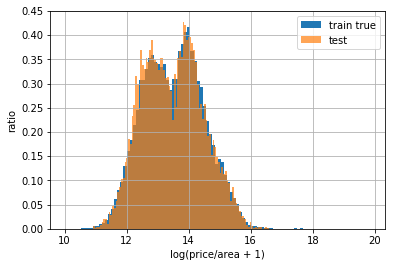

In [54]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

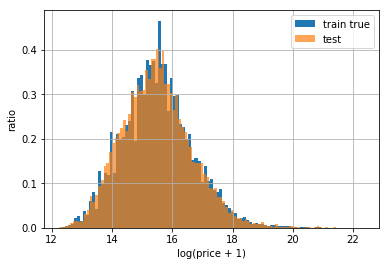

In [55]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

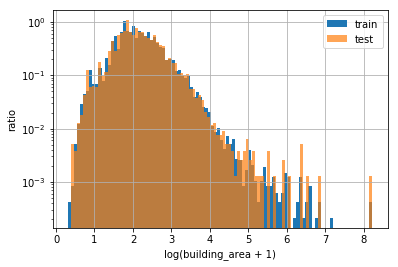

In [56]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

### Make coeffs for opt

In [ ]:
mlist = [3, 4, 5, 8, 10, 12, 13, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27] # get from mean
print([1/len(mlist) if i in mlist else 0 for i in list(range(1,24)) + list(range(25,28))])